# Machine Learning Engineer Nanodegree

## Project: Finding Ships from Satellite images


## Exploring the data

In [1]:
#Import libraries

# for data visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patches
import seaborn as sns
import json,sys
# model selection and metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, confusion_matrix, roc_auc_score
from sklearn.metrics import classification_report
import random as rn
# preprocessing the data
from keras.preprocessing.image import ImageDataGenerator

# tensorflow and keras libraries
import tensorflow as tf
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Flatten, Activation, GlobalAveragePooling2D
from keras.layers import Dropout

# for manipulating images
from PIL import Image



Using TensorFlow backend.


In [2]:
# Loading dataset from shipnet.json file
file = open('shipsnet.json')
dataset = json.load(file)
file.close()

In [3]:
# Viewing the dataset 
df = pd.DataFrame(dataset)
display(df.head(5))

,data,labels,locations,scene_ids
0,"[82, 89, 91, 87, 89, 87, 86, 86, 86, 86, 84, 8...",1,"[-118.2254694333423, 33.73803725920789]",20180708_180909_0f47
1,"[76, 75, 67, 62, 68, 72, 73, 73, 68, 69, 69, 6...",1,"[-122.33222866289329, 37.7491755586813]",20170705_180816_103e
2,"[125, 127, 129, 130, 126, 125, 129, 133, 132, ...",1,"[-118.14283073363218, 33.736016066914175]",20180712_211331_0f06
3,"[102, 99, 113, 106, 96, 102, 105, 105, 103, 10...",1,"[-122.34784341495181, 37.76648707436548]",20170609_180756_103a
4,"[78, 76, 74, 78, 79, 79, 79, 82, 86, 85, 83, 8...",1,"[-122.34852408322172, 37.75878462398653]",20170515_180653_1007


In [4]:
display(df.tail(5))

,data,labels,locations,scene_ids
3995,"[126, 122, 124, 138, 165, 186, 195, 199, 203, ...",0,"[-122.08693255500694, 37.77781408256089]",20170815_180821_102d
3996,"[130, 134, 139, 128, 117, 126, 141, 147, 142, ...",0,"[-122.10549691828378, 37.76946626247702]",20170730_191230_0f21
3997,"[171, 135, 118, 140, 145, 144, 154, 165, 139, ...",0,"[-122.48298739296371, 37.684929808845375]",20161116_180804_0e14
3998,"[85, 90, 94, 95, 94, 92, 93, 96, 93, 94, 94, 9...",0,"[-122.29028216570079, 37.71632091139081]",20170211_181116_0e16
3999,"[122, 122, 126, 126, 142, 153, 174, 190, 185, ...",0,"[-122.49531387721586, 37.698557210117706]",20180206_184438_1043


In [5]:
# The other two columns are not necessay as their values will not help.
# So I am dropping the two columns locations, scene_ids
df = df.drop(['locations','scene_ids'], axis = 1)


In [6]:
# Checking whether the columns were deleted or not
display(df.head())

,data,labels
0,"[82, 89, 91, 87, 89, 87, 86, 86, 86, 86, 84, 8...",1
1,"[76, 75, 67, 62, 68, 72, 73, 73, 68, 69, 69, 6...",1
2,"[125, 127, 129, 130, 126, 125, 129, 133, 132, ...",1
3,"[102, 99, 113, 106, 96, 102, 105, 105, 103, 10...",1
4,"[78, 76, 74, 78, 79, 79, 79, 82, 86, 85, 83, 8...",1


The data we have for an image is in pixel values of 80x80x3. So we have to convert the numerical data into an image

In [7]:
# we have to convert the image data into an image so first we take the input dimensions of the image
pixel_width = 80
pixel_height = 80
numChannels = 3 # its 3D because it's RGB image data
input_shape = (pixel_width, pixel_height,numChannels) 

In [8]:
# we will convert the numerical data into image and append them into a list
images = []
for index in range( len( dataset['data'] )):
    pixel_vals = df['data'][index]
    arr = np.array(pixel_vals).astype('uint8')
    im = arr.reshape((3, 6400)).T.reshape( input_shape )
    images.append( im )

In [9]:
# in order to acess the images converting them into a numpy array
images = np.array(images)
# normalizing the data by converting the values between (0,1)
images = images / 255.0


In [10]:
# creating the labels dataset and doing one-hot-coding for it
labels = dataset['labels']
labels = np_utils.to_categorical(labels)

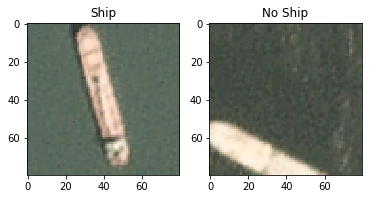

In [11]:
# just plotting some images from the dataset
plt.figure(1)
plt.subplot(1,2,1)
plt.title('Ship')
plt.imshow(images[100])
plt.subplot(1,2,2)
plt.title('No Ship')
plt.imshow(images[2500]);


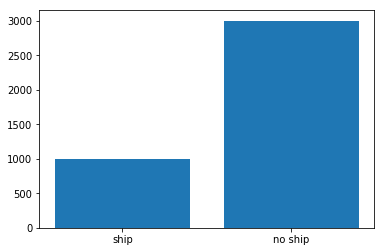

In [12]:
# viewing the dataset in a graph
plt.bar(['ship','no ship'],[sum(df['labels'] == 1),sum(df['labels'] == 0)]);

In [13]:
# splitting the data into training, testing and validation sets
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.10, random_state = 42)
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.10, random_state = 42)

In [14]:
# statistics about the data
print("There are total of %d images" % images.shape[0])
print('Total training images are ', x_train.shape[0])
print('Total testing images are ', x_test.shape[0])
print('Total validation images are ', x_validate.shape[0])

There are total of 4000 images
Total training images are  3240
Total testing images are  400
Total validation images are  360


In [15]:
def find_class_label(data):
    match={
        0:'No Ship',
        1:'Ship'
        }
    return match[data]

## Benchmark model

In [16]:
np.random.seed(48)
tf.set_random_seed(48)

In [17]:
# creating datagen
datagen = ImageDataGenerator(
        rotation_range=25,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,
        vertical_flip = True)

datagen.fit(x_train)

In [18]:
# creating a benchmark model with one layer and least possible filters
bm_model = Sequential()
bm_model.add(Conv2D(2, (2,2), input_shape= input_shape))
bm_model.add(MaxPooling2D(pool_size=(2, 2))) #40x40

bm_model.add(Flatten())
bm_model.add(Dense(2))
bm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 79, 79, 2)         26        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 39, 39, 2)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3042)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 6086      
Total params: 6,112
Trainable params: 6,112
Non-trainable params: 0
_________________________________________________________________


In [19]:
# compiling the model
bm_model.compile(
    loss='categorical_crossentropy',
    optimizer='sgd',
    metrics=['accuracy'])

In [20]:
# creating a checkpointer for accesing the best model
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.bm_model.hdf5', 
                               verbose=1, save_best_only=True)

# fitting the data
bench_results = bm_model.fit_generator(
    datagen.flow(x_train, y_train, batch_size=32),
    epochs=1,
    steps_per_epoch=len(x_train) / 32,
    validation_data=(x_validate,y_validate),
    callbacks=[checkpointer],
    verbose = 1)

Epoch 1/1
102/101 [==============================] - 17s 171ms/step - loss: 3.9821 - acc: 0.2497 - val_loss: 4.0743 - val_acc: 0.2528

Epoch 00001: val_loss improved from inf to 4.07430, saving model to saved_models/weights.best.bm_model.hdf5


In [21]:
bm_model.load_weights('saved_models/weights.best.bm_model.hdf5')
bm_model_predictions = [np.argmax(bm_model.predict(np.expand_dims(tensor, axis=0))) for tensor in x_test]

# report test accuracy
test_accuracy = 100*np.sum(np.array(bm_model_predictions)==np.argmax(y_test, axis=1))/len(bm_model_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 26.7500%


In [22]:
print(classification_report(np.argmax(y_test ,axis=1), bm_model_predictions ,target_names = ['No Ship', 'Ship'] ))

              precision    recall  f1-score   support

     No Ship       0.00      0.00      0.00       293
        Ship       0.27      1.00      0.42       107

   micro avg       0.27      0.27      0.27       400
   macro avg       0.13      0.50      0.21       400
weighted avg       0.07      0.27      0.11       400



C:\Users\ACER\Anaconda3\envs\tf\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ACER\Anaconda3\envs\tf\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ACER\Anaconda3\envs\tf\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


We will take this as benchmark. In here we took all the layers, filters and epochs as minimum as possible. The accuracy, f-score, recall all are as low as possible

## Final model

In [23]:
f_model = Sequential()
f_model.add(Conv2D(32, (3, 3), padding='same', input_shape= input_shape, activation='relu'))
f_model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
f_model.add(MaxPooling2D(pool_size=(2, 2))) 
f_model.add(Dropout(0.25))

f_model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
f_model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
f_model.add(MaxPooling2D(pool_size=(2, 2))) 
f_model.add(Dropout(0.25))

f_model.add(Conv2D(128, (9, 9), padding='same', activation='relu'))
f_model.add(Conv2D(128, (9, 9), padding='same', activation='relu'))
f_model.add(MaxPooling2D(pool_size=(2, 2))) 
f_model.add(Dropout(0.25))

f_model.add(GlobalAveragePooling2D())

f_model.add(Dense(512, activation = 'relu'))

f_model.add(Dense(2, activation='softmax'))

f_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 80, 80, 32)        896       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 80, 80, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 40, 40, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 40, 40, 64)        18496     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 40, 40, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 20, 20, 64)        0         
__________

In [24]:
f_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

In [25]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.f_model.hdf5', 
                               verbose=1, save_best_only=True)

f_model_results = f_model.fit_generator(
    datagen.flow(x_train, y_train, batch_size=32),    
    steps_per_epoch=len(x_train) / 32, 
    epochs = 20,
    validation_data = (x_validate,y_validate),
    callbacks=[checkpointer],
    verbose = 1)

Epoch 1/20
102/101 [==============================] - 9s 85ms/step - loss: 0.5776 - acc: 0.7506 - val_loss: 0.5607 - val_acc: 0.7472

Epoch 00001: val_loss improved from inf to 0.56075, saving model to saved_models/weights.best.f_model.hdf5
Epoch 2/20
102/101 [==============================] - 7s 69ms/step - loss: 0.5462 - acc: 0.7525 - val_loss: 0.5039 - val_acc: 0.7472

Epoch 00002: val_loss improved from 0.56075 to 0.50388, saving model to saved_models/weights.best.f_model.hdf5
Epoch 3/20
102/101 [==============================] - 8s 74ms/step - loss: 0.4091 - acc: 0.8094 - val_loss: 0.2192 - val_acc: 0.9028

Epoch 00003: val_loss improved from 0.50388 to 0.21916, saving model to saved_models/weights.best.f_model.hdf5
Epoch 4/20
102/101 [==============================] - 8s 75ms/step - loss: 0.2450 - acc: 0.8958 - val_loss: 0.2396 - val_acc: 0.9028

Epoch 00004: val_loss did not improve from 0.21916
Epoch 5/20
102/101 [==============================] - 7s 70ms/step - loss: 0.2337 - 

In [26]:
f_model.load_weights('saved_models/weights.best.f_model.hdf5')
f_model_predictions = [np.argmax(f_model.predict(np.expand_dims(tensor, axis=0))) for tensor in x_test]

# report test accuracy
test_accuracy = 100*np.sum(np.array(f_model_predictions)==np.argmax(y_test, axis=1))/len(f_model_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 98.5000%


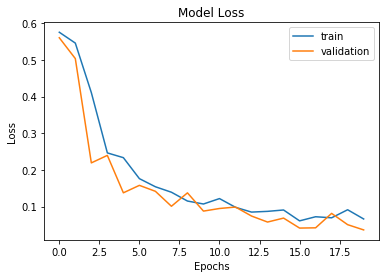

In [27]:
# plotting the model loss graph

plt.plot(f_model_results.history['loss'])
plt.plot(f_model_results.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

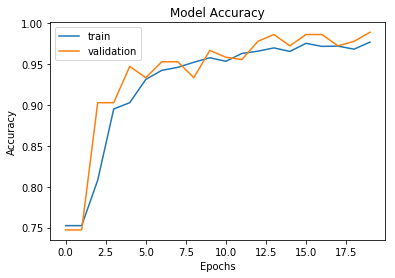

In [28]:
# plotting the model accuracy graph

plt.plot(f_model_results.history['acc'])
plt.plot(f_model_results.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [29]:
# printing the scores of the model
print(classification_report(np.argmax(y_test ,axis=1), f_model_predictions ,target_names = ['No Ship', 'Ship'] ))

              precision    recall  f1-score   support

     No Ship       0.99      0.99      0.99       293
        Ship       0.98      0.96      0.97       107

   micro avg       0.98      0.98      0.98       400
   macro avg       0.98      0.98      0.98       400
weighted avg       0.98      0.98      0.98       400



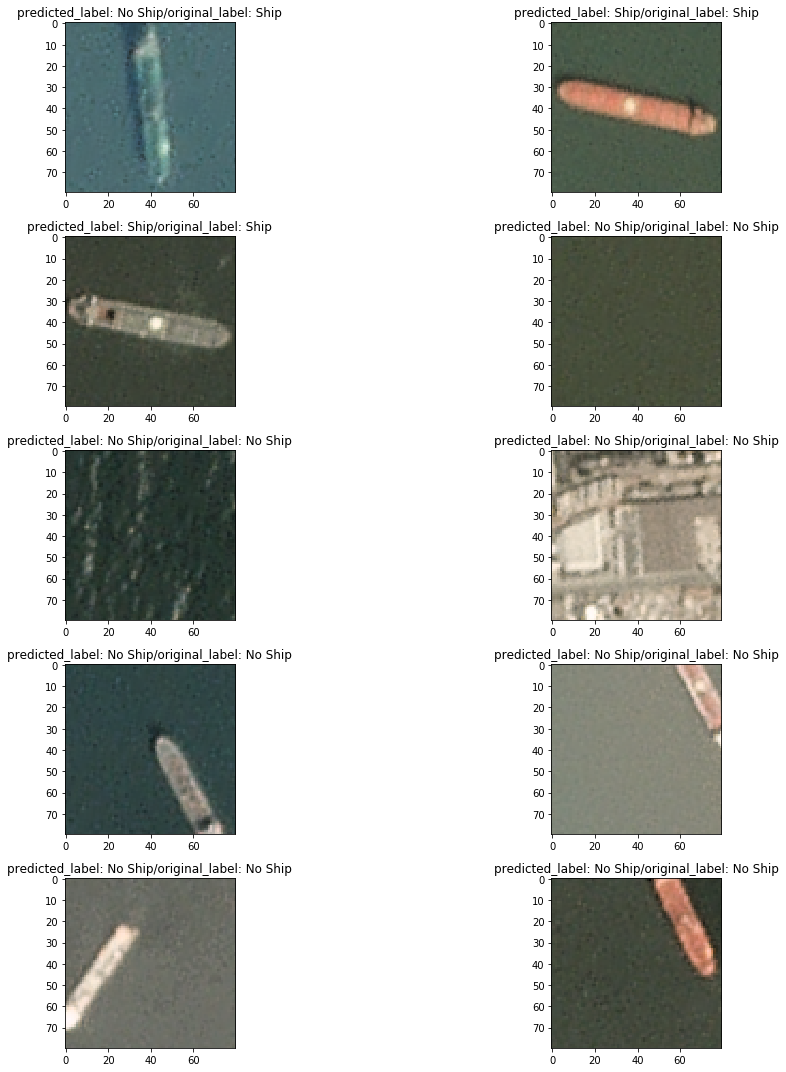

In [30]:
# checking the model
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l= rn.randint(0,len(y_test))
        ax[i,j].imshow(x_test[l])
        ax[i,j].set_title('predicted_label: '+find_class_label(f_model_predictions[l])+'/original_label: '+find_class_label(np.argmax(y_test[l])))
        
plt.tight_layout()

